# Simple Bayesian Network

This notebook tries to assist to accomplish the following:
* Represent the different variables of a bayes network in a simple json like representation (not sure I am successful for that one)
* render this memory representation using Graphviz, showing the graph as well as associated probabilities
* compile a Bayes Model from that json representation.

This notebook is strongly inspired by the examples provided by this [pgmpy_notebook example](https://github.com/pgmpy/pgmpy_notebook). Referring to the pgmpy notebook is strongly suggested to understand how to use it.




## Bayesian Network Configuration
* Fill the structures
* Describe each variables

In [1]:
structures = [('D', 'G'), ('I', 'G'), ('G', 'L'), ('I', 'S')]

variables = {
    'D': {
        'desc': "Difficulty",
        'legend': {0: 'Easy', 1: 'Hard'},
        'cpd': { 0: 0.4, 1: 0.6}
    },
    'I': {
        'desc': "Intelligence",
        'legend': {0: 'Dumb', 1: 'Intelligent'},
        'cpd': { 0: 0.7, 1: 0.3 }
    },
    'G': {
        'desc': "Grade",
        'legend': { 0:'A', 1:'B', 2:'C' },
        'cpd': {
            0: { 'I': { 0: { 'D': { 0: 0.3, 1: 0.05 } },
                        1: { 'D': { 0: 0.9, 1: 0.5 } } } },
            1: { 'I': { 0: { 'D': { 0: 0.4, 1: 0.25 } },
                        1: { 'D': { 0: 0.08, 1: 0.3 } } } },
            2: { 'I': { 0: { 'D': { 0: 0.3, 1: 0.7 } },
                        1: { 'D': { 0: 0.02, 1: 0.2 } } } },
        }
    },
    'L': {
        'desc': "Letter",
        'legend': { 0:'Bad', 1:'Good' },
        'cpd': {
            0: { 'G': { 0: 0.1, 1: 0.4, 2: 0.99 } },
            1: { 'G': { 0: 0.9, 1: 0.6, 2: 0.01 } }
        }
    },
    'S':{
        'desc': "SAT",
        'legend': { 0:'Bad', 1:'Good' },
        'cpd': {
            0: { 'I': { 0: 0.95, 1: 0.2 } },
            1: { 'I': { 0: 0.05, 1: 0.8} }
        }
    }
}

## Render the Graphical Representation of the Bayes Network

Everything here is done in the background by the graphviz_helper

In [2]:
%load_ext autoreload
%autoreload 2

from graphviz_helper import render_graph

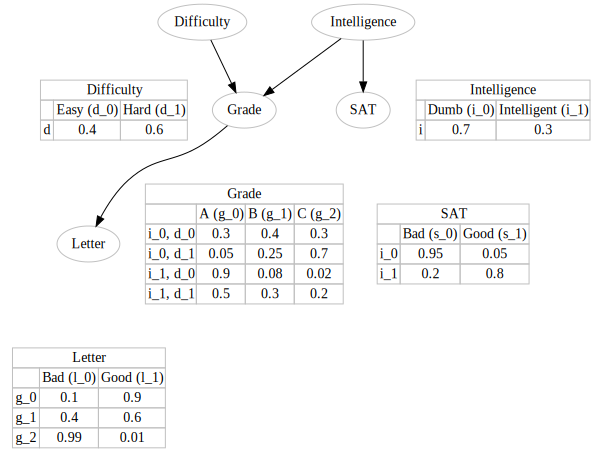

In [30]:
g = render_graph(structures, variables)

g

## Build the Bayes Network Model With pgmpy

Building the model is done in the background by the graphviz_helper.

Once built, the model can be queried.

In [4]:

from graphviz_helper import build_BayesianModel

# Defining the model structure. We can define the network by just passing a list of edges.
model = build_BayesianModel(structures, variables)

model.check_model()

adding cpd_d
adding cpd_i
adding cpd_g
adding cpd_l
adding cpd_s


True

In [5]:
model.get_cpds()

[<TabularCPD representing P(D:2) at 0x111c5d710>,
 <TabularCPD representing P(I:2) at 0x111c5d6a0>,
 <TabularCPD representing P(G:3 | I:2, D:2) at 0x111c5d8d0>,
 <TabularCPD representing P(L:2 | G:3) at 0x1108c8ac8>,
 <TabularCPD representing P(S:2 | I:2) at 0x11861c710>]

In [6]:
print(model.get_cpds('G'))

╒═════╤═════╤══════╤══════╤═════╕
│ I   │ I_0 │ I_0  │ I_1  │ I_1 │
├─────┼─────┼──────┼──────┼─────┤
│ D   │ D_0 │ D_1  │ D_0  │ D_1 │
├─────┼─────┼──────┼──────┼─────┤
│ G_0 │ 0.3 │ 0.05 │ 0.9  │ 0.5 │
├─────┼─────┼──────┼──────┼─────┤
│ G_1 │ 0.4 │ 0.25 │ 0.08 │ 0.3 │
├─────┼─────┼──────┼──────┼─────┤
│ G_2 │ 0.3 │ 0.7  │ 0.02 │ 0.2 │
╘═════╧═════╧══════╧══════╧═════╛


In [7]:
# Getting all the local independencies in the network.
model.local_independencies(['D', 'I', 'S', 'G', 'L'])

(D _|_ I, S)
(I _|_ D)
(S _|_ D, G, L | I)
(G _|_ S | D, I)
(L _|_ D, I, S | G)

In [8]:
# Active trail: For any two variables A and B in a network if any change in A influences the values of B then we say
#               that there is an active trail between A and B.
# In pgmpy active_trail_nodes gives a set of nodes which are affected by any change in the node passed in the argument.
model.active_trail_nodes('D')

{'D': {'D', 'G', 'L'}}

In [9]:
from pgmpy.inference import VariableElimination
infer = VariableElimination(model)
print(infer.query(['G']) ['G'])

╒═════╤══════════╕
│ G   │   phi(G) │
╞═════╪══════════╡
│ G_0 │   0.3030 │
├─────┼──────────┤
│ G_1 │   0.2806 │
├─────┼──────────┤
│ G_2 │   0.4164 │
╘═════╧══════════╛


In [10]:
query_variable = ['G' ,'L', 'S']
evidence = {
    'D': 0, 
    'I': 1
}

for q in query_variable:
    if q not in evidence.keys():
        print(infer.query([q], evidence=evidence) [q])
    else:
        print("{} is observed as {}".format(q,evidence[q]))

╒═════╤══════════╕
│ G   │   phi(G) │
╞═════╪══════════╡
│ G_0 │   0.9000 │
├─────┼──────────┤
│ G_1 │   0.0800 │
├─────┼──────────┤
│ G_2 │   0.0200 │
╘═════╧══════════╛
╒═════╤══════════╕
│ L   │   phi(L) │
╞═════╪══════════╡
│ L_0 │   0.1418 │
├─────┼──────────┤
│ L_1 │   0.8582 │
╘═════╧══════════╛
╒═════╤══════════╕
│ S   │   phi(S) │
╞═════╪══════════╡
│ S_0 │   0.2000 │
├─────┼──────────┤
│ S_1 │   0.8000 │
╘═════╧══════════╛


Predicting values from new data points

Predicting values from new data points is quite similar to computing the conditional probabilities. We need to query for the variable that we need to predict given all the other features. The only difference is that rather than getting the probabilitiy distribution we are interested in getting the most probable state of the variable.

In pgmpy this is known as MAP query. Here's an example:

In [11]:
infer.map_query(query_variable)

{'G': 2, 'L': 0, 'S': 0}

In [12]:

infer.map_query(query_variable, evidence=evidence)

{'G': 0, 'L': 1, 'S': 1}